In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zhuya\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [3]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_win2_load_all.d2v'

In [4]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [5]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [6]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win2_load_all.d2v


In [7]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [8]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.9926796 , -0.95616704, -0.41943806,  1.05640149, -0.17750672,
       -0.22473556, -1.14849627, -1.04512095,  0.72278821, -0.26906219,
       -0.12173071,  0.27951074,  0.85554093,  1.4066658 , -0.66658169,
       -3.5733881 ,  0.61995304, -2.23058319, -0.13402276,  2.12668133,
       -0.35180882, -0.27377269,  0.54994392, -1.48118317, -1.4935751 ,
       -1.68159318,  0.34006077,  2.6541965 , -0.45972574, -0.43201742,
        0.3170231 , -1.63518965,  2.0632391 ,  1.46774471, -0.95080161,
        0.16261423,  1.81780541,  0.94335526, -0.02719352,  0.66872084,
        0.53617448,  0.2284466 ,  1.14089978, -1.53023636, -0.30838454,
        1.86624837, -0.64276832,  0.49743181, -0.53058469,  1.06889701,
        0.34412953,  0.14060664,  1.23631251,  0.41249499, -0.50394237,
        0.92049599,  0.2226413 , -0.11276353, -0.56527591,  0.82244128,
       -0.99196661, -0.42952666, -0.88652813,  0.43424979, -1.98911691,
        1.09482539, -2.45888305,  1.73302603,  2.20067   , -0.60

In [9]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [10]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [11]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

[0]	train-mlogloss:2.12045	valid-mlogloss:2.13881
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.07997	valid-mlogloss:1.42203
[50]	train-mlogloss:0.638973	valid-mlogloss:1.15602
[75]	train-mlogloss:0.402763	valid-mlogloss:1.039
[100]	train-mlogloss:0.271432	valid-mlogloss:0.979978
[125]	train-mlogloss:0.192646	valid-mlogloss:0.954811
[150]	train-mlogloss:0.140118	valid-mlogloss:0.946211
[175]	train-mlogloss:0.10349	valid-mlogloss:0.948864
[200]	train-mlogloss:0.077589	valid-mlogloss:0.956714
[225]	train-mlogloss:0.059765	valid-mlogloss:0.964432
[250]	train-mlogloss:0.047164	valid-mlogloss:0.975061
Stopping. Best iteration:
[157]	train-mlogloss:0.128527	valid-mlogloss:0.945539

final validation loss:
0.945539156439
final validation accuracy:
0.672086720867
[0]	train-mlogloss:2.12061	valid-mlogloss:2.13901
Multiple eval metrics have been passed: 'valid-mlogloss

[275]	train-mlogloss:0.03961	valid-mlogloss:0.879211
Stopping. Best iteration:
[178]	train-mlogloss:0.103409	valid-mlogloss:0.868814

final validation loss:
0.868813624121
final validation accuracy:
0.682926829268
[0]	train-mlogloss:2.12076	valid-mlogloss:2.14444
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.09726	valid-mlogloss:1.46298
[50]	train-mlogloss:0.649115	valid-mlogloss:1.20091
[75]	train-mlogloss:0.412992	valid-mlogloss:1.09002
[100]	train-mlogloss:0.280211	valid-mlogloss:1.03516
[125]	train-mlogloss:0.199066	valid-mlogloss:1.0131
[150]	train-mlogloss:0.144817	valid-mlogloss:1.00789
[175]	train-mlogloss:0.106608	valid-mlogloss:1.00701
[200]	train-mlogloss:0.079416	valid-mlogloss:1.01444
[225]	train-mlogloss:0.06062	valid-mlogloss:1.02495
[250]	train-mlogloss:0.047597	valid-mlogloss:1.03454
Stopping. Best iteration:
[173]	train-mlogloss:0.109232	va

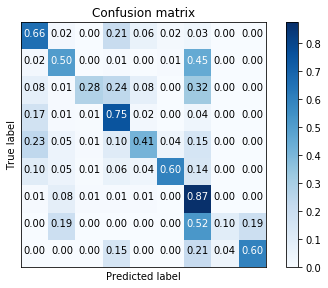

In [13]:
y_predict = xgbclassifier(train_set, train_y, test_set, 10, 8, 1000)

In [14]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin2load10fold.csv")